In [ ]:
# Transfer learning menggunakan EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path dataset
trainPath = "D:/dataset_bungaCrop/train"
validPath = "D:/dataset_bungaCrop/val"

# Data augmentation dan preprocessing
trainGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # <--- Sesuai standar EfficientNetB0
    rotation_range=30,                         # ditingkatkan
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, 
    brightness_range=(0.5, 1.5),
    fill_mode='nearest'
).flow_from_directory(trainPath, target_size=(224, 224), batch_size=32, class_mode='categorical')

validGenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(validPath, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 278 images belonging to 29 classes.
Found 74 images belonging to 29 classes.


In [10]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Jumlah kelas sesuai folder train
num_classes = 29  # Ubah ke 29 jika memang hanya 29 kelas

# Layer input eksplisit
input_tensor = Input(shape=(224, 224, 3))

# Base model dari EfficientNetB0
baseModel = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Head model
x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Model final
model = Model(inputs=input_tensor, outputs=predictions)

# Freeze sebagian besar layer
for layer in baseModel.layers:
    layer.trainable = False  # Fine-tune nanti di tahap 2 training

# Compile model
optimizer = Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Summary
model.summary()

# plot_model(model, show_shapes=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,415,680 (16.84 MB)

 Trainable params: 365,341 (1.39 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint_cb = ModelCheckpoint(
    "best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1
)

# Callback untuk menghentikan training jika tidak ada peningkatan
earlystop_cb = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
)

# Callback untuk menurunkan learning rate jika val_loss stagnan
lr_reduce_cb = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Latih model
history = model.fit(
    trainGenerator,
    validation_data=validGenerator,
    epochs=100,
    callbacks=[checkpoint_cb, lr_reduce_cb]
)


c:\Users\ASUS\Documents\Python\BRIN\MobileNetV3\envi_V3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0081 - loss: 4.5077
Epoch 1: val_accuracy improved from -inf to 0.08108, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.0095 - loss: 4.4935 - val_accuracy: 0.0811 - val_loss: 3.3727 - learning_rate: 1.0000e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0176 - loss: 4.2729
Epoch 2: val_accuracy improved from 0.08108 to 0.09459, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.0184 - loss: 4.2587 - val_accuracy: 0.0946 - val_loss: 3.3255 - learning_rate: 1.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0507 - loss: 3.9958
Epoch 3: val_accuracy improved from 0.09459 to 0.12162, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.0510 - loss: 3.9940 - val_accuracy: 0.1216 - val_loss: 3.2763 - learning_rate: 1.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0637 

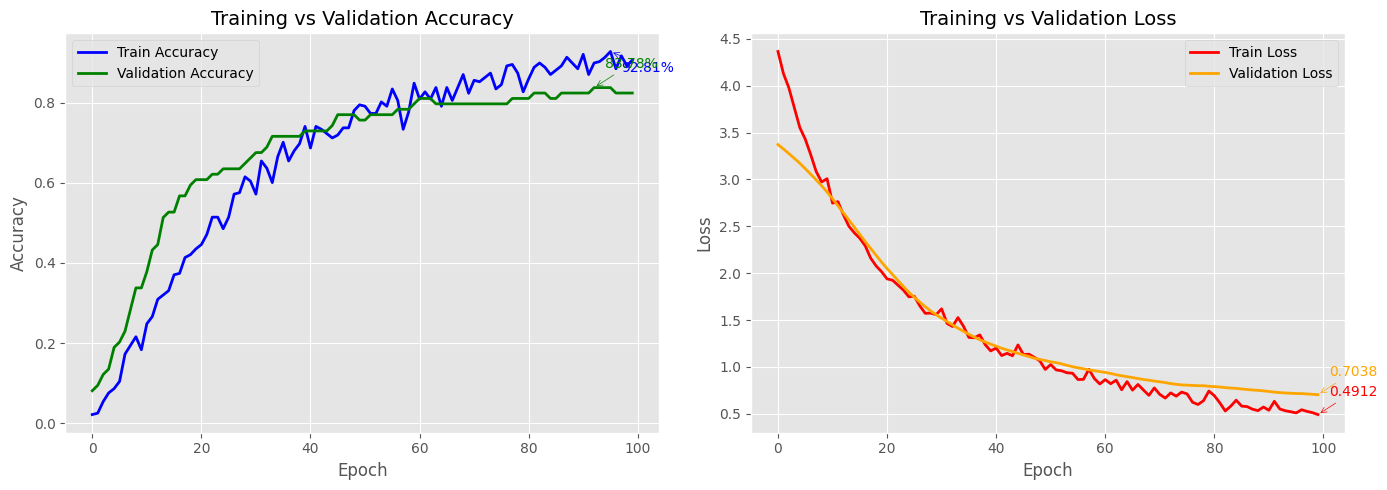

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure(figsize=(14, 5))
 
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Cari nilai maksimum dan epoch-nya
max_train_acc = max(train_acc)
epoch_max_train = train_acc.index(max_train_acc)

max_val_acc = max(val_acc)
epoch_max_val = val_acc.index(max_val_acc)

# Cari loss terendah (optional)
min_train_loss = min(train_loss)
epoch_min_train_loss = train_loss.index(min_train_loss)

min_val_loss = min(val_loss)
epoch_min_val_loss = val_loss.index(min_val_loss)

# --- Plot Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', color='green', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend()

# Anotasi train accuracy tertinggi
plt.annotate(f"{max_train_acc*100:.2f}%", 
             xy=(epoch_max_train, max_train_acc), 
             xytext=(epoch_max_train+2, max_train_acc-0.05),
             arrowprops=dict(arrowstyle="->", color='blue'),
             color='blue', fontsize=10)

# Anotasi val accuracy tertinggi
plt.annotate(f"{max_val_acc*100:.2f}%", 
             xy=(epoch_max_val, max_val_acc), 
             xytext=(epoch_max_val+2, max_val_acc+0.05),
             arrowprops=dict(arrowstyle="->", color='green'),
             color='green', fontsize=10)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', color='red', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()

# Anotasi loss terendah (optional)
plt.annotate(f"{min_train_loss:.4f}", 
             xy=(epoch_min_train_loss, min_train_loss), 
             xytext=(epoch_min_train_loss+2, min_train_loss+0.2),
             arrowprops=dict(arrowstyle="->", color='red'),
             color='red', fontsize=10)

plt.annotate(f"{min_val_loss:.4f}", 
             xy=(epoch_min_val_loss, min_val_loss), 
             xytext=(epoch_min_val_loss+2, min_val_loss+0.2),
             arrowprops=dict(arrowstyle="->", color='orange'),
             color='orange', fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
# Evaluasi model di data validasi
loss, acc = model.evaluate(validGenerator, verbose=1)

# Ambil akurasi terbaik selama training
train_acc_max = max(history.history['accuracy'])
val_acc_max = max(history.history['val_accuracy'])

# Cetak hasil
print("\n📊 Evaluasi Model")
print("=" * 40)
print(f"🔹 Akurasi Train Tertinggi  : {train_acc_max * 100:.2f}%")
print(f"🔹 Akurasi Valid Tertinggi  : {val_acc_max * 100:.2f}%")
print(f"🔹 Akurasi Valid Terakhir   : {acc * 100:.2f}%")
print(f"🔹 Loss Valid Terakhir      : {loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8223 - loss: 0.7360

📊 Evaluasi Model
🔹 Akurasi Train Tertinggi  : 92.81%
🔹 Akurasi Valid Tertinggi  : 83.78%
🔹 Akurasi Valid Terakhir   : 82.43%
🔹 Loss Valid Terakhir      : 0.7038


In [14]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path folder test
test_root = "D:/dataset_bungaCrop/test"

# Ambil label kelas dari train generator (pastikan 'trainGenerator' sudah tersedia sebelumnya)
class_labels = list(trainGenerator.class_indices.keys())

# Untuk menyimpan hasil prediksi
predictions = []

print("📦 Memulai prediksi gambar di folder test...\n")

# Loop setiap folder kelas
for class_dir in sorted(os.listdir(test_root)):
    class_path = os.path.join(test_root, class_dir)
    if not os.path.isdir(class_path):
        continue

    # Loop setiap gambar dalam folder kelas
    for fname in sorted(os.listdir(class_path)):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, fname)

        # Preprocessing gambar (mengikuti preprocessing MobileNetV3)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)  # <- penting: pakai ini sesuai training

        # Prediksi gambar
        pred = model.predict(img_array, verbose=0)
        predicted_class = np.argmax(pred)
        confidence = np.max(pred)

        # Simpan hasil
        true_label = class_dir
        predicted_label = class_labels[predicted_class]
        predictions.append((fname, true_label, predicted_label, confidence))

        # Tampilkan hasil prediksi
        print(f"📷 {fname}")
        print(f"   ✅ Ground Truth : {true_label}")
        print(f"   🧠 Prediksi     : {predicted_label} ({confidence * 100:.2f}%)\n")

# Hitung akurasi prediksi di folder test
correct = sum(1 for p in predictions if p[1] == p[2])
total = len(predictions)

if total > 0:
    accuracy = 100 * correct / total
    print(f"\n✅ Akurasi di folder test: {correct}/{total} = {accuracy:.2f}%")
else:
    print("⚠️ Tidak ada gambar yang diproses di folder test.")



📦 Memulai prediksi gambar di folder test...

📷 1.jpg
   ✅ Ground Truth : Affinis
   🧠 Prediksi     : Affinis (85.33%)

📷 14.jpg
   ✅ Ground Truth : Affinis
   🧠 Prediksi     : Affinis (88.41%)

📷 5.JPG
   ✅ Ground Truth : Affinis
   🧠 Prediksi     : Affinis (99.23%)

📷 15.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (91.30%)

📷 2.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (99.30%)

📷 3.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (97.73%)

📷 15.jpg
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (84.19%)

📷 18.jpg
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (96.25%)

📷 5.jpg
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (94.95%)

📷 10.jpg
   ✅ Ground Truth : Callistophylla
   🧠 Prediksi     : Callistophylla (46.40%)

📷 4.JPG
   ✅ Ground Truth : Callistophylla
   🧠 Prediksi     : Callistophylla (97.41%)

📷 3.JPG
   ✅ Ground Truth : Clemensiorum
   🧠 Prediksi     : Clemensiorum (88.

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


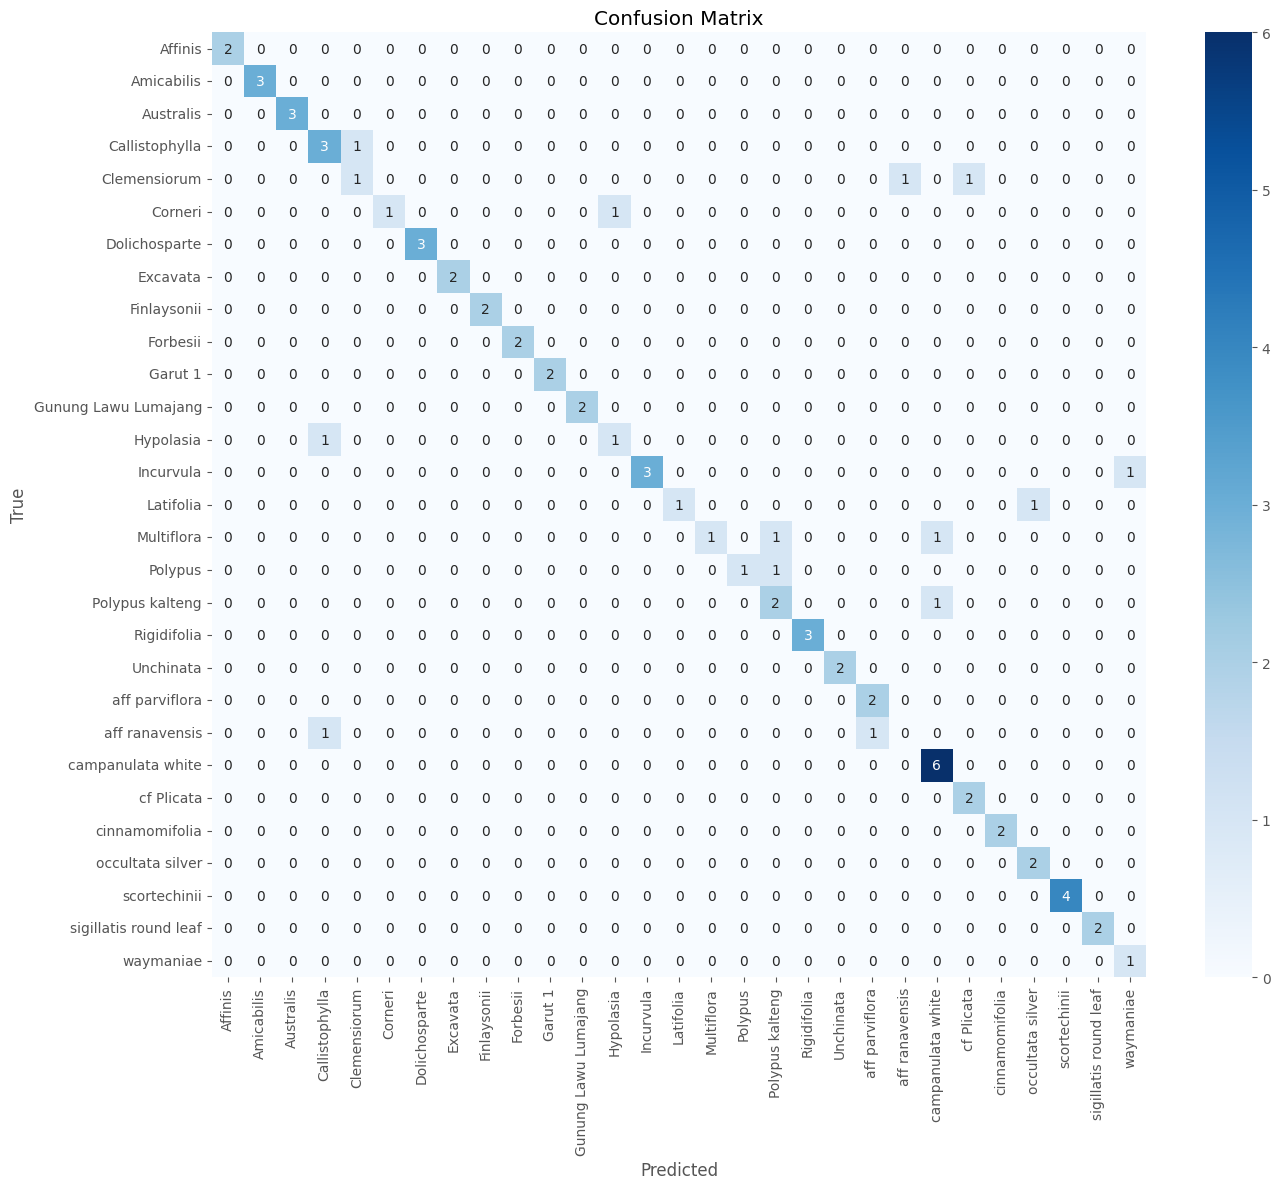

📋 Classification Report:
                       precision    recall  f1-score   support

              Affinis       1.00      1.00      1.00         2
           Amicabilis       1.00      1.00      1.00         3
            Australis       1.00      1.00      1.00         3
       Callistophylla       0.60      0.75      0.67         4
         Clemensiorum       0.50      0.33      0.40         3
              Corneri       1.00      0.50      0.67         2
        Dolichosparte       1.00      1.00      1.00         3
             Excavata       1.00      1.00      1.00         2
          Finlaysonii       1.00      1.00      1.00         2
             Forbesii       1.00      1.00      1.00         2
              Garut 1       1.00      1.00      1.00         2
 Gunung Lawu Lumajang       1.00      1.00      1.00         2
            Hypolasia       0.50      0.50      0.50         2
            Incurvula       1.00      0.75      0.86         4
            Latifolia       1

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi semua batch validasi
Y_pred = model.predict(validGenerator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validGenerator.classes
labels = list(validGenerator.class_indices.keys())

# Validasi jumlah label
if len(np.unique(y_true)) != len(labels):
    print(f"⚠️ Jumlah kelas y_true = {len(np.unique(y_true))}, tapi jumlah label di generator = {len(labels)}")
    print("Pastikan semua kelas ada minimal 1 gambar di folder validasi.")
else:
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))


In [16]:
import tensorflow as tf

# Konversi langsung dari model terlatih di memori
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file .tflite
with open("model/mobilenetv2_bunga.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model langsung disimpan sebagai TFLite: mobilenetv2_bunga.tflite")


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp85hhmcvv\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmp85hhmcvv\assets


Saved artifact at 'C:\Users\ASUS\AppData\Local\Temp\tmp85hhmcvv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_247')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  2296535407024: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2296535407200: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2296533267408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552755392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552764368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552766480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552754160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552757680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552760496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2296552760144: TensorSpec(shape=(), dtype=tf.resour

# Untuk cek folder test

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# === Path ke model TFLite ===
tflite_model_path = "C:/Users/ASUS/Documents/Python/BRIN/MobileNetV2/model/mobilenetv2_daun.tflite"  # Ubah ke model bunga jika perlu

# === Load interpreter TFLite ===
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"✅ Model TFLite dimuat: {tflite_model_path}\n")

# === Path folder test ===
test_root = "D:/dataset_daun/test"

# Ambil label kelas dari trainGenerator
class_labels = list(trainGenerator.class_indices.keys())

predictions = []

print("📦 Mulai prediksi gambar di folder test...\n")

# Loop folder kelas
for class_dir in sorted(os.listdir(test_root)):
    class_path = os.path.join(test_root, class_dir)
    if not os.path.isdir(class_path):
        continue

    for fname in sorted(os.listdir(class_path)):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, fname)

        # Preprocessing gambar
        img = image.load_img(img_path, target_size=(320, 320))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array.astype(np.float32))  # Sesuaikan dtype

        # Inferensi TFLite
        interpreter.set_tensor(input_details[0]['index'], img_array)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_details[0]['index'])

        predicted_class = np.argmax(pred)
        confidence = np.max(pred)

        true_label = class_dir
        predicted_label = class_labels[predicted_class]
        predictions.append((fname, true_label, predicted_label, confidence))

        print(f"📷 {fname}")
        print(f"   ✅ Ground Truth : {true_label}")
        print(f"   🧠 Prediksi     : {predicted_label} ({confidence * 100:.2f}%)\n")

# === Hitung Akurasi Test ===
correct = sum(1 for p in predictions if p[1] == p[2])
total = len(predictions)

if total > 0:
    accuracy = 100 * correct / total
    print(f"\n✅ Akurasi di folder test: {correct}/{total} = {accuracy:.2f}%")
else:
    print("⚠️ Tidak ada gambar yang diproses di folder test.")


c:\Users\ASUS\Documents\Python\BRIN\MobileNetV3\envi_V3\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


✅ Model TFLite dimuat: C:/Users/ASUS/Documents/Python/BRIN/MobileNetV2/model/mobilenetv2_daun.tflite

📦 Mulai prediksi gambar di folder test...

📷 1.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (25.99%)

📷 12.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (18.70%)

📷 8.JPG
   ✅ Ground Truth : Amicabilis
   🧠 Prediksi     : Amicabilis (70.88%)

📷 1.JPG
   ✅ Ground Truth : Anulata
   🧠 Prediksi     : Mamasa (29.75%)

📷 12.JPG
   ✅ Ground Truth : Anulata
   🧠 Prediksi     : Towutiensis (30.79%)

📷 9.JPG
   ✅ Ground Truth : Anulata
   🧠 Prediksi     : Minahassae (39.76%)

📷 1.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (60.47%)

📷 12.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (98.18%)

📷 28.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Towutiensis (55.98%)

📷 4.JPG
   ✅ Ground Truth : Australis
   🧠 Prediksi     : Australis (63.08%)

📷 1.JPG
   ✅ Ground Truth : Callistophylla
   🧠 Prediksi     : Callis